# Machine Learning - Project - Group XXXXX
## Group Members
|Name|StudentID|
|:-----------:|:--------:|
|Fabio Lopes|20200597|
|Filipe Costa||
|Jorge Pereira||
## Introduction 
Put some introduction here

## Package Instalation and Importing

In [1]:
#!{sys.executable} -m pip install -U xlrd
#!{sys.executable} -m pip install -U xgboost
#!{sys.executable} -m pip install -U hyperopt
#!{sys.executable} -m pip install -U mlflow

In [2]:
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from hyperopt import STATUS_OK, fmin, hp, tpe, Trials
import mlflow
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
import time

## Import Train and Test Data

In [3]:
data = pd.read_excel('Train.xlsx')
data_test = pd.read_excel("Test.xlsx")

C:\anaconda3\lib\site-packages\xlrd\xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


In [4]:
print(f"Training data has {data.shape[1]} columns and {data.shape[0]} rows.")

Training data has 15 columns and 22400 rows.


In [5]:
data.head(5)

,CITIZEN_ID,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Income
0,12486,Mr. Adam Glover,"July 1,2003",Europe,Married,Wife,Northbury,High School + PostGraduation,13,Private Sector - Services,Repair & constructions,40,0,2273,1
1,12487,Mr. Cameron McDonald,"January 25,2006",Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,Repair & constructions,40,0,0,1
2,12488,Mr. Keith Davidson,"May 10,2009",Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Sales,46,0,2321,1
3,12489,Mr. Alexander Gill,"March 25,1985",Europe,Married,Wife,Northbury,High School - 2nd Cycle,11,Private Sector - Services,Security,37,5395,0,1
4,12490,Mr. Neil Piper,"May 29,2015",Europe,Single,Other Family,Northbury,PhD,21,Self-Employed (Individual),Professor,45,0,0,1


## Data Cleansing & Feature Engineering Functions
In this section, we will define the Cleansing functions

In [6]:
def strip_lower(df):
    """Detects the String columns and converts all the records to lowercase."""
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].apply(str.strip).apply(str.lower)
    return df

In [7]:
def fill_missing_values(df,ColumnswithMissingValues):
    for column in ColumnswithMissingValues:
        ColumnMode = df[column].mode()[0]
        df[column] = df[column].str.replace('?',ColumnMode, regex=False)
    return df

In [8]:
def ComputeAgeAt2048(Birthday):
    CurrentYear=datetime(2048,1,1)
    
    s_YearOfBirth = Birthday.split(",")[1]
    YearOfBirth = datetime(int(s_YearOfBirth),1,1)
        
    return CurrentYear.year - YearOfBirth.year

In [9]:
def ClassifyCitizen(Difference):
    if Difference == 0:
        return 'A' # Chosen carefully from volunteers
    elif Difference > 0:
        return 'B' # Invited
    elif Difference < 0:
        return 'C' # Paid

In [10]:
def encode_data(data, nominal_variables):
    data_Encoded = data.copy()
    dummies = pd.get_dummies(data_Encoded[nominal_variables], prefix=nominal_variables)
    data_Encoded = pd.concat([data_Encoded,dummies],axis=1)
    data_Encoded = data_Encoded.drop(nominal_variables, axis =1)
    return data_Encoded

In [11]:
def normalize_df(df,features):
    scaler = StandardScaler()
    df_standard = df.copy()
    scaled_feat = scaler.fit_transform(df_standard[features])
    df_standard[features] = scaled_feat
    return df_standard

In [12]:
def resample_df(df):
    class0 = df[df['Income'] == 0]
    class1 = df[df['Income'] == 1]
    
    oversample = resample(class1, 
                       replace=True, 
                       n_samples=len(class0), #set the number of samples to equal the number of the majority class
                       random_state=42)
    
    oversample_data = pd.concat([oversample, class0])
    return oversample_data

In [13]:
def AlignDataframe(ColumnsInModel,df):
    dummy_df = pd.DataFrame(columns=ColumnsInModel)
    dummy_df, aligned_df = dummy_df.align(df,fill_value=0,join='left',axis=1)
    return aligned_df

In [14]:
def DataPreparation(df):
    # Lowers all case in string variables
    new_df = df.copy()
    
    new_df = strip_lower(new_df)
    
    # Deals with missing values
    ColumnswithMissingValues = ['Role','Employment Sector','Base Area']
    new_df = fill_missing_values(new_df,ColumnswithMissingValues)
    
    # Computes Age
    new_df['Age'] = new_df['Birthday'].apply(ComputeAgeAt2048)
    new_df.drop('Birthday', axis=1, inplace=True)
    
    # Classifies Citizen
    new_df['Group'] = (new_df['Money Received'] - new_df['Ticket Price']).apply(ClassifyCitizen)
    
    # Creates Ordinal Variable from Education
    EducationClassification = {
                            "phd" : 16,
                            "masters + postgraduation" : 15,
                            "masters" : 14,
                            "bachelors + postgraduation" : 13,
                            "bachelors" : 12,
                            "professional school + postgraduation" : 11,
                            "high school + postgraduation" : 10,
                            "professional school" : 9,
                            "high school complete" : 8,
                            "high school - 2nd cycle" : 7,
                            "high school - 1st cycle" : 6,
                            "middle school complete" : 5,
                            "middle school - 2nd cycle" : 4,
                            "middle school - 1st cycle" : 3,
                            "primary school" : 2,
                            "preschool" : 1
                            }
    new_df['Education_Class'] = new_df['Education Level'].map(EducationClassification)
    new_df.drop('Education Level', axis=1, inplace=True)
    
    # Performs one hot encoding in nominal variables
    NominalVariables = ['Native Continent', 
                        'Marital Status', 
                        'Lives with', 
                        'Base Area', 
                        'Employment Sector', 
                        'Role', 
                        'Group']
    
    new_df = encode_data(new_df, NominalVariables)
    
    # Normalize numerical variables
    metric_features = ['Years of Education',
                       'Working Hours per week',
                       'Money Received',
                       'Ticket Price',
                       'Age']
    
    new_df = normalize_df(new_df,metric_features)
    
    # Drops the Name column and selects Citizen ID as the index
    new_df = new_df.drop(['Name'], axis =1)
    new_df.set_index(["CITIZEN_ID"],inplace=True)
    
    return new_df

In [15]:
prepped_data = DataPreparation(data)
prepped_data.head(5)

,Years of Education,Working Hours per week,Money Received,Ticket Price,Income,Age,Education_Class,Native Continent_africa,Native Continent_america,Native Continent_asia,...,Role_management,Role_other services,Role_professor,Role_repair & constructions,Role_sales,Role_security,Role_transports,Group_A,Group_B,Group_C
CITIZEN_ID,,,,,,,,,,,,,,,,,,,,,
12486,-0.069210,-0.039108,-0.143582,4.325999,1,0.469929,10,0,0,0,...,0,0,0,1,0,0,0,0,0,1
12487,-0.467237,-0.039108,-0.143582,-0.218204,1,0.250170,9,0,0,0,...,0,0,0,1,0,0,0,1,0,0
12488,-0.467237,0.445911,-0.143582,4.421961,1,0.030410,9,0,0,0,...,0,0,0,0,1,0,0,0,0,1
12489,-0.865263,-0.281618,0.441079,-0.218204,1,1.788488,7,0,0,0,...,0,0,0,0,0,1,0,0,1,0
12490,3.115002,0.365074,-0.143582,-0.218204,1,-0.409110,16,0,0,0,...,0,0,1,0,0,0,0,1,0,0


## Model Creation
In this section, we will create the models.

### Helper Functions

In [16]:
def plot_cf(y, y_pred):
    cf_matrix = confusion_matrix(y_test, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [17]:
def metrics(y_train, pred_train , y_val, pred_val):
    print('___________________________________________________________________________________________________________')
    print('                                                     TRAIN                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_train, pred_train))
    cf_matrix = confusion_matrix(y_train, pred_train)
    print(cf_matrix)
    print("F1: {}".format(f1_score(y_train, pred_train, average='macro')))



    print('___________________________________________________________________________________________________________')
    print('                                                VALIDATION                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val))
    cf_matrix = confusion_matrix(y_val, pred_val)
    print(cf_matrix)
    print("F1: {}".format(f1_score(y_val, pred_val, average='macro')))

In [18]:
def run_model(model,X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    labels_train = model.predict(X_train)
    labels_val = model.predict(X_test)
    metrics(y_train, labels_train, y_test, labels_val)
    plot_cf(y_test,labels_val)

In [19]:
def objective(space):
    classifier = xgb.XGBClassifier(n_estimators = space['n_estimators']
                                 , max_depth = int(space['max_depth'])
                                 , learning_rate = space['learning_rate']
                                 , gamma = space['gamma']
                                 , min_child_weight = space['min_child_weight']
                                 , subsample = space['subsample']
                                 , colsample_bytree = space['colsample_bytree'])
  
    classifier.fit(optimizer_X_train, optimizer_y_train)
    accuracies = cross_val_score(estimator = classifier, X = optimizer_X_train, y = optimizer_y_train, cv = 5, scoring = 'f1_macro')
    CrossValMean = accuracies.mean()
  
    return{'loss':1-CrossValMean, 'status': STATUS_OK }

### Split Training Data

In [20]:
target = 'Income'

X = prepped_data[[x for x in prepped_data.columns if x != target]]
y = prepped_data[[x for x in prepped_data.columns if x == target]]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0, stratify=y)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

### Logistic Regression

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     13671
           1       0.75      0.60      0.66      4249

    accuracy                           0.86     17920
   macro avg       0.82      0.77      0.79     17920
weighted avg       0.85      0.86      0.85     17920

[[12821   850]
 [ 1714  2535]]
F1: 0.7866157459646367
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-------------------------------------------------------------------------------

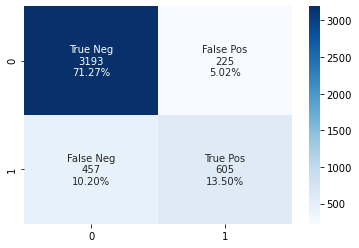

In [21]:
log_model = LogisticRegression(max_iter=1000000)
run_model(log_model,X_train, X_test, y_train, y_test)

### K Nearest Neighbours

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     13671
           1       0.78      0.73      0.75      4249

    accuracy                           0.89     17920
   macro avg       0.85      0.83      0.84     17920
weighted avg       0.88      0.89      0.89     17920

[[12803   868]
 [ 1166  3083]]
F1: 0.8391811090325085
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-------------------------------------------------------------------------------

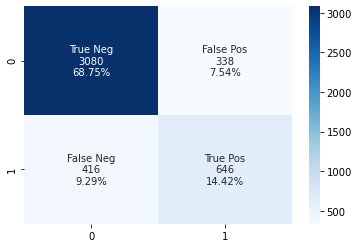

In [22]:
modelKNN = KNeighborsClassifier()
run_model(modelKNN,X_train, X_test, y_train, y_test)

### Naive Bayes

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.34      0.50     13671
           1       0.31      0.97      0.47      4249

    accuracy                           0.49     17920
   macro avg       0.64      0.65      0.49     17920
weighted avg       0.82      0.49      0.49     17920

[[4586 9085]
 [ 124 4125]]
F1: 0.48576459044328213
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
----------------------------------------------------------------------------------

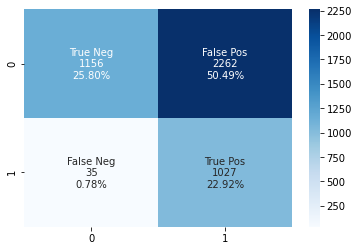

In [23]:
modelNAB = GaussianNB()
run_model(modelNAB,X_train, X_test, y_train, y_test)

### XGBoost

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.96      0.94     13671
           1       0.84      0.71      0.77      4249

    accuracy                           0.90     17920
   macro avg       0.88      0.83      0.85     17920
weighted avg       0.90      0.90      0.90     17920

[[13095   576]
 [ 1236  3013]]
F1: 0.852054456285966
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
--------------------------------------------------------------------------------

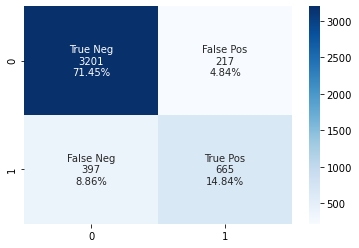

In [24]:
modelXGB = xgb.XGBClassifier()
run_model(modelXGB,X_train, X_test, y_train, y_test)

## Feature Selection
In this section, we will eliminate noise from the model.

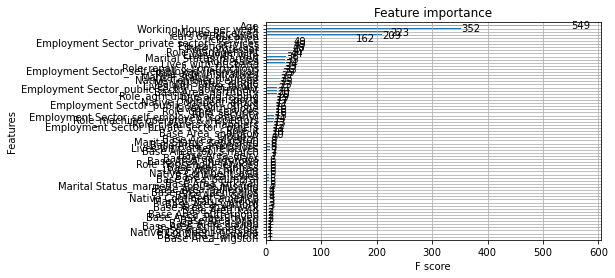

In [25]:
xgb.plot_importance(modelXGB)

In [26]:
# Fit model using each importance as a threshold
thresholds = np.sort(modelXGB.feature_importances_)

for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(modelXGB, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = xgb.XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    print("Thresh=%.9f, nFeatures=%d, F1: %.2f%%" % (thresh, select_X_train.shape[1], f1*100.0))

Thresh=0.000000000, nFeatures=88, F1: 79.83%
Thresh=0.000000000, nFeatures=88, F1: 79.83%
Thresh=0.000000000, nFeatures=88, F1: 79.83%
Thresh=0.000000000, nFeatures=88, F1: 79.83%
Thresh=0.000000000, nFeatures=88, F1: 79.83%
Thresh=0.000000000, nFeatures=88, F1: 79.83%
Thresh=0.000000000, nFeatures=88, F1: 79.83%
Thresh=0.000000000, nFeatures=88, F1: 79.83%
Thresh=0.000000000, nFeatures=88, F1: 79.83%
Thresh=0.000000000, nFeatures=88, F1: 79.83%
Thresh=0.000000000, nFeatures=88, F1: 79.83%
Thresh=0.000000000, nFeatures=88, F1: 79.83%
Thresh=0.000000000, nFeatures=88, F1: 79.83%
Thresh=0.000000000, nFeatures=88, F1: 79.83%
Thresh=0.000000000, nFeatures=88, F1: 79.83%
Thresh=0.000000000, nFeatures=88, F1: 79.83%
Thresh=0.000000000, nFeatures=88, F1: 79.83%
Thresh=0.000000000, nFeatures=88, F1: 79.83%
Thresh=0.000000000, nFeatures=88, F1: 79.83%
Thresh=0.000615356, nFeatures=69, F1: 79.83%
Thresh=0.000673374, nFeatures=68, F1: 79.56%
Thresh=0.000864094, nFeatures=67, F1: 79.91%
Thresh=0.0

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     13671
           1       0.82      0.69      0.75      4249

    accuracy                           0.89     17920
   macro avg       0.87      0.82      0.84     17920
weighted avg       0.89      0.89      0.89     17920

[[13046   625]
 [ 1308  2941]]
F1: 0.8418405100555155
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-------------------------------------------------------------------------------

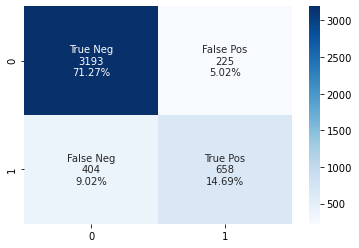

In [27]:
# I choose Threshold 0.007776021
VariableSelector = SelectFromModel(modelXGB, threshold=0.007776021, prefit=True)
selected_X_train = VariableSelector.transform(X_train)
selected_X_test = VariableSelector.transform(X_test)
modelXGB = xgb.XGBClassifier()
run_model(modelXGB,selected_X_train, selected_X_test, y_train, y_test)

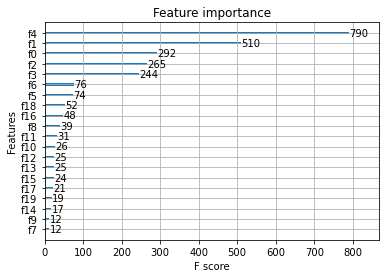

In [28]:
xgb.plot_importance(modelXGB)

### Hyperpatameterization of XGBoost

In [29]:
space = {'max_depth' : hp.choice('max_depth', range(2, 20, 1))
         , 'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01)
         , 'n_estimators' : hp.choice('n_estimators', range(10, 50, 5))
         , 'gamma' : hp.quniform('gamma', 0, 0.50, 0.01)
         , 'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1)
         , 'subsample' : hp.quniform('subsample', 0.1, 1, 0.01)
         , 'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1, 0.01)}

In [30]:
optimizer_X_train = selected_X_train
optimizer_y_train = y_train

start_time = time.time()

best = fmin(fn=objective
          , space=space
          , algo=tpe.suggest
          , max_evals=1000
          , trials=Trials()
          , verbose = True)
print("Best: ", best)
print("--- %s seconds ---" % (time.time() - start_time))

100%|████████████████████████████████████████████| 1000/1000 [18:24<00:00,  1.10s/trial, best loss: 0.1900894376923905]
Best:  {'colsample_bytree': 0.9500000000000001, 'gamma': 0.23, 'learning_rate': 0.35000000000000003, 'max_depth': 4, 'min_child_weight': 2.0, 'n_estimators': 7, 'subsample': 0.89}
--- 1104.1325254440308 seconds ---


___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     13671
           1       0.79      0.56      0.65      4249

    accuracy                           0.86     17920
   macro avg       0.83      0.75      0.78     17920
weighted avg       0.85      0.86      0.85     17920

[[13025   646]
 [ 1890  2359]]
F1: 0.7808425119786648
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-------------------------------------------------------------------------------

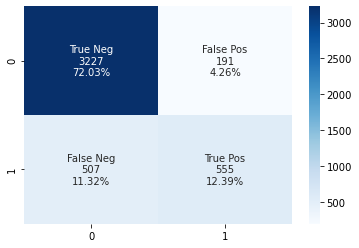

In [34]:
modelXGB = xgb.XGBClassifier(n_estimators = best['n_estimators']
                                 , max_depth = int(best['max_depth'])
                                 , learning_rate = best['learning_rate']
                                 , gamma = best['gamma']
                                 , min_child_weight = best['min_child_weight']
                                 , subsample = best['subsample']
                                 , colsample_bytree = best['colsample_bytree'])

run_model(modelXGB,selected_X_train, selected_X_test, y_train, y_test)

## Produce File for Submission

In [41]:
prepped_data_test = DataPreparation(data_test)
prepped_data_test = AlignDataframe(X_train.columns,prepped_data_test)

In [42]:
selected_prepped_data_test = VariableSelector.transform(prepped_data_test)

In [43]:
predictions = modelXGB.predict(selected_prepped_data_test)
predictions

array([1, 0, 1, ..., 0, 0, 0], dtype=int64)

In [44]:
prepped_data_test['Income'] = predictions

In [45]:
prepped_data_test[['Income']].to_csv('Submission.csv')